In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import autoreload

from Network import *
%load_ext autoreload
%autoreload 2

D:\AppDownloads\anaconda3\envs\face_detection\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## 数据集获取与数据预处理

In [12]:
def get_video_length(video_path):
    """
        给入视频路径，计算视频的长度以及FPS

        return:
        video_length:视频的长度，单位：s
        fps_counter：视频的帧率
    """
    video_capture = cv2.VideoCapture(video_path)

    frame_counter = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    fps_counter = video_capture.get(cv2.CAP_PROP_FPS)
    video_length = frame_counter/fps_counter

    video_capture.release()
    
    return video_length,fps_counter

def get_clip_hr_path_VIPL(cache_root_path,dataset_path):
    """
       获取所有clip以及HR路径
    """
#     without_glasses = [12,14,18,19,23,26,28,34,38,39,40,41,48,52,57,58,63,65,67,70,71,74,79,84,85,91,92,95,97,99]
    without_glasses = list(range(1,108))
    
    all_clip_path = []
    HR_gt_path = []
    for dirpath, dirnames, filenames in os.walk(cache_root_path):
        for dir in dirnames:
            if 'clip' in dir and int(dirpath.split("\\")[-2][1:]) in without_glasses:
                all_clip_path.append(os.path.join(dirpath,dir))  #  D:\ECNU\Graduation_Project\code\VIPL-HR-cache-filtered\p1\v1\clip1
                
                person_id,video_id = int(dirpath.split("\\")[-2][1:]),int(dirpath.split("\\")[-1][1:])   #  54,1
                hr_path_1 = os.path.join(dataset_path,"p{}-{}".format((person_id-1)//5*5+1 if person_id<=100 else 101,
                                                                    (person_id-1)//5*5+5 if person_id<=100 else 107))
                hr_path = os.path.join(hr_path_1,"p{}\\v{}\\source2\\gt_HR.csv".format(person_id,video_id))
                HR_gt_path.append(hr_path)
    
    return all_clip_path,HR_gt_path

def get_clip_hr_path_ECNU(cache_root_path,dataset_path,HR_root_path):
    """
       获取所有clip以及HR路径
    """
    all_clip_path = []
    HR_gt_path = []
    for dirpath, dirnames, filenames in os.walk(cache_root_path):
        for dir in dirnames:
            if 'clip' in dir:
                person_id = int(dirpath.split("\\")[-1])   #  1
                hr_path = os.path.join(HR_root_path,"{}.txt".format(person_id))
                if os.path.exists(hr_path):
                    all_clip_path.append(os.path.join(dirpath,dir))  #  D:\ECNU\Graduation_Project\code\ECNU-Dataset-cache-filtered\1\clip1
                    HR_gt_path.append(hr_path)
    
    return all_clip_path,HR_gt_path

def get_data_from_file_VIPL(all_clip_path,HR_gt_path,ROI_ids):
    """
       从文件读取缓存的数据以及ground truth心率信息
       
       params:
       clip_path:clip的路径
       HR_gt_path:心率文件路径
       ROI_ids:用于训练的ROI区域编号
       
       return:
       all_signal:list of numpy array, element shape:(num_ROI,num_frame)
       all_HR_gt:list of numpy array, element shape:(num_HR,)
    """
    ROI_filename_list = ["channel_G_ROI_{}.txt".format(id) for id in ROI_ids]
    
    all_signal = []
    all_HR_gt = []
    for clip_path,hr_path in zip(all_clip_path,HR_gt_path):
        data = []
        HR_gt = []
        for filename in ROI_filename_list:
            with open(os.path.join(clip_path,filename),'r') as f:
                data.append([float(d) for d in f.read().split()])
        with open(hr_path,'r') as f:
            HR_gt = [float(d) for d in f.read().split() if d != 'HR']
        all_signal.append(np.array(data))
        all_HR_gt.append(np.array(HR_gt))
    
    return all_signal, all_HR_gt

def get_data_from_file_ECNU(all_clip_path,HR_gt_path,ROI_ids):
    """
       从文件读取缓存的数据以及ground truth心率信息
       
       params:
       clip_path:clip的路径
       HR_gt_path:心率文件路径
       ROI_ids:用于训练的ROI区域编号
       
       return:
       all_signal:list of numpy array, element shape:(num_ROI,num_frame)
       all_HR_gt:list of numpy array, element shape:(num_HR,)
    """
    ROI_filename_list = ["channel_G_ROI_{}.txt".format(id) for id in ROI_ids]
    
    all_signal = []
    all_HR_gt = []
    for clip_path,hr_path in zip(all_clip_path,HR_gt_path):
        data = []
        HR_gt = []
        for filename in ROI_filename_list:
            with open(os.path.join(clip_path,filename),'r') as f:
                data.append([float(d) for d in f.read().split()])
        hr = pd.read_csv(hr_path,usecols=['PR'],index_col=False)
        hr = np.squeeze(hr.values)
        
        num_frame = len(data[0])
        num_hr = len(hr)
        
        for i in range(num_frame):
            center = np.round(i * num_hr / num_frame)
            chop_length = num_hr // num_frame
            start,stop = max(int(center - np.ceil(chop_length / 2)),0),min(int(center + np.ceil(chop_length / 2)),num_hr)
            HR_gt.append(np.mean(hr[start:stop]))
        
        all_signal.append(np.array(data))
        all_HR_gt.append(np.array(HR_gt))
    
    return all_signal, all_HR_gt

def show_signal(signal,fps):
    """
       可视化信号
    """
    plt.figure(figsize=(16, 7))
    
    plt.xlabel("Time/s")

    #  设置坐标轴刻度及范围
    xticks = np.round(np.arange(0,len(signal)/fps+0.001,len(signal)/fps/10),2)
    plt.xticks(xticks)
    plt.xlim([0,len(signal)/fps])

    yticks = np.arange(min(signal)-1,max(signal)+1,(max(signal)-min(signal)+2)/10)
    plt.yticks(yticks)
    plt.ylim([min(signal)-1,max(signal)+1])

    x = np.round(np.arange(0,len(signal),1) / fps,2)
    plt.plot(x,signal,"g-")

def HR_expand(all_signal,all_HR_gt):
    """
       把心率信号扩展到和视频帧对应的长度
       params:
       all_signal:list of numpy array, element shape:(num_ROI,num_frame)
       all_HR_gt:list of numpy array, element shape:(num_HR,)
       
       return:
       expand_HR_gt:list of numpy array, element shape:(num_frame,)
    """
    expand_HR_gt = []
    for signal,HR_gt in zip(all_signal,all_HR_gt):
        repeat = [signal.shape[1] // len(HR_gt)] * (len(HR_gt) - 1) + [signal.shape[1] - (len(HR_gt) - 1) * (signal.shape[1] // len(HR_gt))]
        expand_hr = np.concatenate([[hr] * r for hr,r in zip(HR_gt,repeat)])
        expand_HR_gt.append(expand_hr)
    
    return expand_HR_gt

def crop_signal(all_signal,expanded_HR_gt,crop_length,stride,data_aug=False):
    """
       把信号都剪成一样的切片大小
       params:
       all_signal:list of numpy array, element shape:(num_ROI,num_frame)
       expand_HR_gt:list of numpy array, element shape:(num_frame,)
       crop_length:片段长度，单位：帧
       stride:片段开头间距，单位：帧
       
       return:
       cropped_signal:numpy array,shape:(num_sample,crop_length,num_ROI)
       cropped_HR:numpy array,shape:(num_sample,)
    """
    cropped_signal = []
    cropped_HR = []
    for signal,expanded_hr in zip(all_signal,expanded_HR_gt):
        signal = signal.T   #  shape:(num_frame,num_ROI)
        
        #  正向序列
        signal_gen = TimeseriesGenerator(signal, signal, length=crop_length, stride=stride, batch_size=1)
        hr_gen = TimeseriesGenerator(expanded_hr, expanded_hr, length=crop_length, stride=stride, batch_size=1)
        if data_aug:
            #  反向序列
            rev_signal_gen = TimeseriesGenerator(signal, signal, length=crop_length, stride=stride, batch_size=1, reverse=True)
            rev_signal_iterator = iter(rev_signal_gen)
            
        signal_iterator = iter(signal_gen)
        hr_iterator = iter(hr_gen)
        
        while True:
            try:
                hr = next(hr_iterator)[0][0]
                cropped_signal.append(next(signal_iterator)[0][0])   #  shape:(crop_length,num_ROI)
                cropped_HR.append(hr)   #  shape:(crop_length,)
                if data_aug:
                    cropped_signal.append(next(rev_signal_iterator)[0][0])   #  shape:(crop_length,num_ROI)
                    cropped_HR.append(hr)   #  shape:(crop_length,)
            except StopIteration:
                break
    
    return np.array(cropped_signal),np.mean(np.array(cropped_HR),axis=-1)

def data_normalization(data,axis,data_type='signal'):
    """
       数据归一化，信号数据进行高斯归一，GT心率值归一化到[0,1]之间
       
       params:
       data:要归一化的数据,shape:(num_sample,crop_length,num_ROI)
       axis:指定归一化的维度
       data_type:指定归一化的数据类型,eg.signal/hr
    """
    if data_type == 'signal':
        mean = np.mean(data,axis,keepdims=True)  #  shape:num_sample*1*num_ROI
        std = np.std(data,axis,keepdims=True)  #  shape:num_sample*1*num_ROI
        
        data = (data - mean) / std
        return data
    elif data_type == 'hr':
        #  假设心率值在40~150bpm之间
        data = (data - 40) / 110
        return data
    
def denormalize_HR(batch_HR):
    return batch_HR * 110 + 40

### 数据获取

In [2]:
dataset_source = "ECNU"

if dataset_source == "ECNU":
    cache_root_path = "./cache/filtered/ECNU-Dataset-cache-filtered-span10"
    HR_root_path = "D:\\BaiduNetdiskDownload\\心率实测值"
    dataset_path = "D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1"
    ROI_ids = [8,9,10,11,12]

    all_clip_path, HR_gt_path = get_clip_hr_path_ECNU(cache_root_path,dataset_path,HR_root_path)
    all_signal, all_HR_gt = get_data_from_file_ECNU(all_clip_path,HR_gt_path,ROI_ids)
    
    for dirpath, _, filenames in os.walk(dataset_path):
        file_abspath = os.path.join(dirpath,filenames[0])
        break
    _,fps = get_video_length(file_abspath)
    
    print(all_signal[0].shape)
    print(all_HR_gt[0].shape)
elif dataset_source == 'VIPL':
    cache_root_path = "./cache/filtered/VIPL-HR-cache-filtered-span10"
    dataset_path = "D:\\BaiduNetdiskDownload\\VIPL-HR\\data"
    ROI_ids = [8,9,10,11,12]

    all_clip_path, HR_gt_path = get_clip_hr_path_VIPL(cache_root_path,dataset_path)
    all_signal, all_HR_gt = get_data_from_file_VIPL(all_clip_path,HR_gt_path,ROI_ids)
    expanded_HR_gt = HR_expand(all_signal,all_HR_gt)
    
    fps = 25
    
    print(all_signal[0].shape)
    print(all_HR_gt[0].shape)
    print(expanded_HR_gt[0].shape)

### 数据预处理，归一化及数据反向

In [5]:
if dataset_source == "ECNU":
    cropped_signal,cropped_HR = crop_signal(all_signal,all_HR_gt,crop_length = 200,stride = 70,data_aug=True)
    
    norm_signal = data_normalization(cropped_signal,axis=1,data_type='signal')
    norm_HR = data_normalization(cropped_HR,axis=None,data_type='hr')

    norm_signal = np.transpose(norm_signal,(0,2,1))
elif dataset_source == 'VIPL':
    cropped_signal,cropped_HR = crop_signal(all_signal,expanded_HR_gt,crop_length = 200,stride = 70,data_aug=True)
    
    #  把方差极大的信号先去掉
    selected_signal = []
    selected_HR = []
    for i in range(len(cropped_signal)):
        temp_signal = []
        for j in range(len(ROI_ids)):
            signal_std = np.std(cropped_signal[i,:,j])

            if signal_std < 3:
                temp_signal.append(cropped_signal[i,:,j])
        if len(temp_signal) == 5:
            selected_signal.append(cropped_signal[i,:,:])
            selected_HR.append(cropped_HR[i])

    selected_signal = np.array(selected_signal)
    selected_HR = np.array(selected_HR)
    
    norm_signal = data_normalization(selected_signal,axis=1,data_type='signal')
    norm_HR = data_normalization(selected_HR,axis=None,data_type='hr')
    norm_signal = np.transpose(norm_signal,(0,2,1))

print(norm_signal.shape)
print(norm_HR.shape)

(3062, 5, 200)
(3062,)


## 自适应加权网络可视化分析

### 导入模型

In [6]:
HR_test_model = HR_network(input_shape=norm_signal.shape[1:])  #  eg.input_shape:batch*5*200
HR_test_model.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss='mse',metrics=["mae","mape"])

### 获得自适应加权网络部分的模型

In [7]:
weight_model = Model(inputs=HR_test_model.input,outputs=HR_test_model.get_layer(index=18).output)
weighted_HR_model = Model(inputs=HR_test_model.input,outputs=HR_test_model.get_layer(index=21).output)

weighted_HR_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reshape_input (InputLayer)      [(None, 5, 200)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 5, 200, 1)    0           reshape_input[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 100, 16)   64          reshape[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5, 100, 16)   64          conv2d[0][0]                     
____________________________________________________________________________________________

### 随机选择64个例子

In [21]:
random_idx = np.random.choice(np.arange(len(norm_signal)),64,replace=False)
test_sample = (norm_signal[random_idx],norm_HR[random_idx])

weights = weight_model.predict_on_batch(test_sample)
weighted_HR = weighted_HR_model.predict_on_batch(test_sample)
HR = HR_test_model.predict_on_batch(test_sample)
print(weights.shape)
print(weighted_HR.shape)
print(HR.shape)

(64, 5)
(64, 200)
(64, 1)


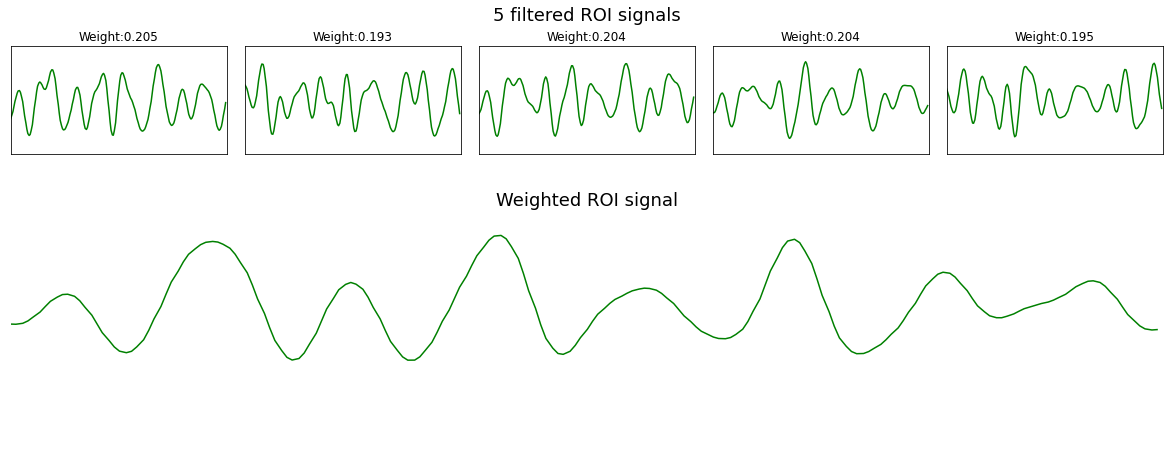

In [22]:
idx = 61

sample,hr = test_sample[0][idx],denormalize_HR(test_sample[1][idx])
sample_weights = weights[idx].numpy()
sample_weighted_hr = weighted_HR[idx].numpy()

plt.figure(figsize=(16,7))

rect_lines_up = []
for i in range(5):
    rect_lines_up.append([i * (0.25 + 3) / 16.,0.607,3./16.,1.5/7.])
rect_line_down = [0,0.036,1,4/7.]

#  图1
plt.suptitle("{} filtered ROI signals".format(weights.shape[1]), fontsize=18, y=0.9)
for i,rect_line in enumerate(rect_lines_up):
    ax = plt.axes(rect_line)
    plt.xlim([0,sample.shape[1]/fps])
    plt.ylim([min(sample[i])-1,max(sample[i])+1])

    x = np.round(np.arange(0,sample.shape[1],1) / fps,2)
    plt.plot(x,sample[i],"g-")
    plt.title("Weight:{:.3f}".format(sample_weights[i]))
    plt.xticks([])
    plt.yticks([])
#  图2
ax = plt.axes(rect_line_down)
plt.title("Weighted ROI signal", fontsize=18, y=0.8)

plt.xlim([0,len(sample_weighted_hr)/fps])
plt.ylim([min(sample_weighted_hr)-1,max(sample_weighted_hr)+1])

x = np.round(np.arange(0,len(sample_weighted_hr),1) / fps,2)
plt.plot(x,sample_weighted_hr,"g-")
plt.axis('off')
plt.show()